In [18]:
import matplotlib.pyplot as plt 
from archivos.carga_datos import *
from gurobipy import GRB, Model, quicksum
from gurobipy import *
import numpy as np

paises = ["Chile", "Argentina"]
tipos = ["Hortofruticola", "Congelado", "Refrigerado"]
rutas = ["Norte", "Centro", "Sur"]

alimentos, cant_por_tipo, total_alimentos = alimentos(tipos)
peso_promedio = peso_promedio(tipos)
costo_adicional_camiones = costo_adicional_camiones()
costo_combustible = costo_combustible()
costo_fijo_almacenamiento = costo_fijo_almacenamiento()
costo_mantencion = costo_mantencion()
costo_ruta = costo_ruta()
costo_unitario_almacenamiento = costo_unitario_almacenamiento()
demanda = demanda(tipos)
distancia_por_pais = distancia_por_pais(rutas)
stock_inicial = stock_inicial(tipos)
sueldo = sueldo()

cant_de_centros = 1
cant_de_bodegas = 1
cant_de_camiones = 15
P_m = 31000

pruebas = [0,1,2]
demandas = [1,1.25,1.5]
array_camiones =  [9,13,17]
mult_costo_alm = [1,1.5,2]

tmax = 10
T = range(1, tmax + 1)    #tiempo
I = range(1, len(cant_por_tipo) + 1) # Tipos de alimentos 1: Hortofrutícola 2:Congelado 3:Refrigerado
A = range(1, cant_por_tipo[0] + 1) # Alimentos de cada tipo
J = range(1, cant_de_centros + 1) # Cantidad de centros de distribución
K = range(1, cant_de_bodegas + 1) # Cantidad de bodegas de almacenamiento
R = range(1, len(rutas) + 1) # 1:Norte, 2:Centro, 3:Sur
P = range(1, len(paises) + 1) # 1:Chile, 2:Argentina
E = range(1, cant_de_camiones + 1)

dict_rutas = {1:"Norte", 2:"Centro", 3:"Sur"}
dict_paises = {1:"Chile", 2:"Argentina"}

dict_tipos = dict(zip(I, tipos))
# dict_tipos =  {1: 'Hortofruticola', 2: 'Congelado', 3: 'Refrigerado'}

dict_alimentos = {}
for i in I:
    dict_alimentos[i] = dict(zip(A,alimentos[dict_tipos[i]]))

P_ai = {(a,i): float(peso_promedio[dict_tipos[i]][dict_alimentos[i][a]]) for i in I for a in A}
flota_de_camiones = np.array([cant_de_camiones,cant_de_camiones,cant_de_camiones])
N_i = {(i): flota_de_camiones[j] for (i,j) in zip(I,range(len(I)))}
R_i = {"1": "Norte", "2": "Centro", "3": "Sur"}
V_m = 90 # 90 m3 es lo más común en camiones de transporte de alimentos, ver fuentes de abajo. 
P_m = 25000 # 31000 kg es lo más común en camiones de transporte de alimentos, ver fuentes de abajo. 
CFB_i = {(i): int(costo_fijo_almacenamiento[dict_tipos[i]]) for i in I}
CTr_i = {(i): int(costo_adicional_camiones[dict_tipos[i]]) for i in I}

q_ai = {(a,i): int(stock_inicial[dict_tipos[i]][dict_alimentos[i][a]]) for i in I for a in A}

l_rp = {(r,p): int(distancia_por_pais[dict_rutas[r]][dict_paises[p]]) for r in R for p in P}
PC_p = {(p): int(int(costo_combustible[dict_paises[p]])) for p in P}
PT_r = {(r): int(costo_ruta[dict_rutas[r]]) for r in R}
S_r = {(r): int(sueldo[dict_rutas[r]]) for r in R}
M_r = {(r): int(costo_mantencion[dict_rutas[r]]) for r in R}

Omega = 10000000
# Propiedades de los alimentos

P_ai = {(a,i): float(peso_promedio[dict_tipos[i]][dict_alimentos[i][a]]) for i in I for a in A}

# Al[a,i,k,t,prueba,p] ExT[a,i,k,t,prueba,p] Tr[a,i,j,k,t,e,prueba,p] Cam[e,i,j,k,t,prueba,p]

Tr = np.zeros((cant_por_tipo[0],len(cant_por_tipo),cant_de_centros,cant_de_bodegas,tmax,cant_de_camiones, len(pruebas), 3))
Al = np.zeros((cant_por_tipo[0], len(cant_por_tipo),cant_de_bodegas,tmax,len(pruebas), 3))
ExT = np.zeros((cant_por_tipo[0], len(cant_por_tipo),cant_de_bodegas,tmax,len(pruebas), 3))
Cam = np.zeros((cant_de_camiones,len(cant_por_tipo),cant_de_centros,cant_de_bodegas,tmax,len(pruebas), 3))

print(f"Tr.shape={Tr.shape}")


Tr.shape=(10, 3, 1, 1, 10, 15, 3, 3)


In [24]:
for prueba in pruebas:
    for p in range(3):
        if prueba == 1:
            cant_de_camiones = array_camiones[p]
        if prueba == 2:
            CAl_i = {(i): float(costo_unitario_almacenamiento[dict_tipos[i]])*mult_costo_alm[p] for i in I} # Arreglar este valor
        else:
            CAl_i = {(i): float(costo_unitario_almacenamiento[dict_tipos[i]]) for i in I} # Arreglar este valor

        if prueba == 0:
            d_ai = {(a,i): int(round(int(demanda[dict_tipos[i]][dict_alimentos[i][a]])*demandas[p])) for i in I for a in A}
        else:
            d_ai = {(a,i): int(round(int(demanda[dict_tipos[i]][dict_alimentos[i][a]]))) for i in I for a in A}

        if prueba == 0:
            suffix = "demanda_" + str(demandas[p])
        elif prueba == 1:
            suffix = "costo_almacenar_" + str(mult_costo_alm[p])
        elif prueba == 2:
            suffix = "camiones_" + str(array_camiones[p])
        else:
            raise ValueError("Prueba = {prueba} no existe.")

        tr_name = "resultados/resultados_Tr_" + suffix + ".csv"
        with open(tr_name, "r") as file:
            datos = file.readlines()
            file.close()
            datos.pop(0)
            for linea in datos:
                data = linea.strip(" \n").split(",") # Tr,a,i,j,k,t,e, prueba, p
                data = [int(datum) for datum in data]
                Tr[data[1]-1,data[2]-1,data[3]-1,data[4]-1,data[5]-1,data[6]-1, prueba, p] = data[0]

        cam_name = "resultados/resultados_Cam_" + suffix + ".csv"
        with open(cam_name, "r") as file:
            datos = file.readlines()
            file.close()
            datos.pop(0)
            for linea in datos:
                data = linea.strip(" \n").split(",") # Cam,e,i,j,k,t, prueba, p
                data = [int(datum) for datum in data]
                Cam[data[1]-1,data[2]-1,data[3]-1,data[4]-1,data[5]-1, prueba, p] = data[0]

        al_name = "resultados/resultados_Al_" + suffix + ".csv"
        with open(al_name, "r") as file:
            datos = file.readlines()
            file.close()
            datos.pop(0)
            for linea in datos:
                data = linea.strip(" \n").split(",") # Al[a,i,k,t]
                data = [int(datum) for datum in data]
                Al[data[1]-1,data[2]-1,data[3]-1,data[4]-1, prueba, p] = data[0]

        ext_name = "resultados/resultados_ExT_" + suffix + ".csv"
        with open(ext_name, "r") as file:
            datos = file.readlines()
            file.close()
            datos.pop(0)
            for linea in datos:
                data = linea.strip(" \n").split(",") # ExT[a,i,k,t]
                data = [int(datum) for datum in data]
                ExT[data[1]-1,data[2]-1,data[3]-1,data[4]-1, prueba, p] = data[0]

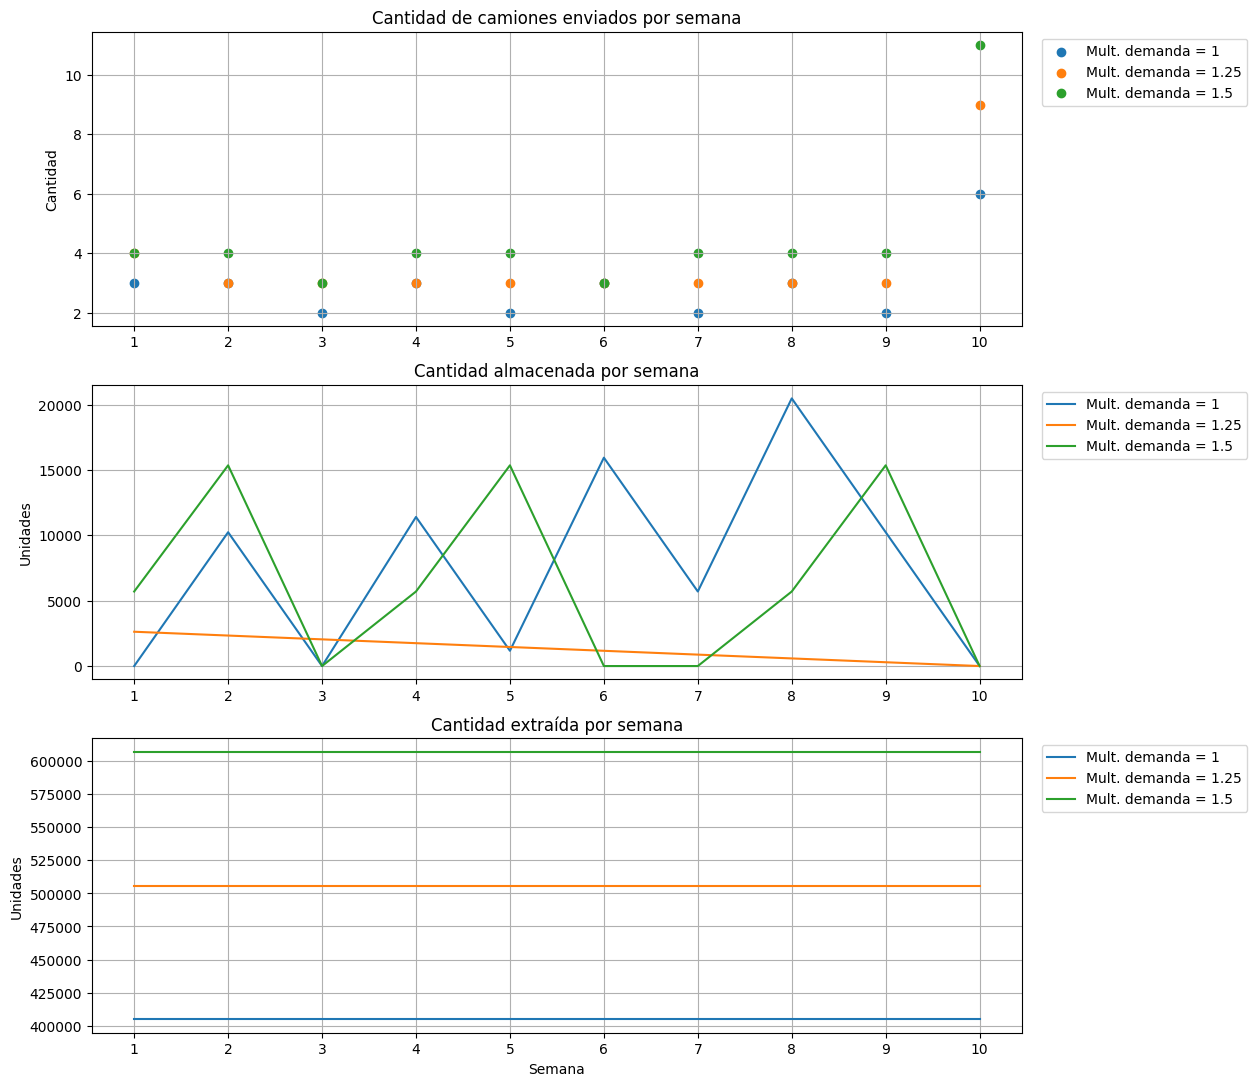

In [20]:
# Prueba 0: cambiar demanda, ver cambio de almacenamiento + extracción y cambio de cantidad de camiones transportados


# pruebas = [0,1,2]
# demandas = [1,1.25,1.5]



#### Prueba 0
cam_comparison = np.zeros((tmax, 3))
al_comparison = np.zeros((tmax, 3))
ext_comparison = np.zeros((tmax, 3))
prueba = 0
for p in range(3):
    # Tr[a,i,j,k,t,e, prueba, p]
    # Cam[e,i,j,k,t, prueba, p]
    # Al[a,i,k,t, prueba, p]
    # ExT[a,i,k,t, prueba, p]
    Cam_sum_t = np.sum(Cam[:,:,:,:,:,0,p], axis=(0,1,2,3)) # [tiempos, 0, p=p]
    cam_comparison[:,p] = Cam_sum_t
    Al_sum_t = np.sum(Al[:,:,:,:,0,p], axis=(0,1,2))
    # print(Al_sum_t.shape)
    al_comparison[:,p] = Al_sum_t
    ExT_sum_t = np.sum(ExT[:,:,:,:,0,p], axis=(0,1,2))
    # print(ExT_sum_t.shape)
    ext_comparison[:,p] = ExT_sum_t

fig, ax = plt.subplots(3,1)
fig.set_size_inches(12,13)
for p in range(3):
    ax[0].scatter(T, cam_comparison[:,p], label=f"Mult. demanda = {demandas[p]}")
    ax[0].set_title("Cantidad de camiones enviados por semana")
    ax[1].plot(T, al_comparison[:,p], label=f"Mult. demanda = {demandas[p]}")
    ax[1].set_title("Cantidad almacenada por semana")
    ax[2].plot(T, ext_comparison[:,p], label=f"Mult. demanda = {demandas[p]}")
    ax[2].set_title("Cantidad extraída por semana")
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
# fig.suptitle("Comparación según multiplicador de demanda")
ax[0].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[1].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[2].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[2].set_xlabel("Semana")
ax[0].set_ylabel("Cantidad")
ax[1].set_ylabel("Unidades")
ax[2].set_ylabel("Unidades")
# ax.ticklabel_format(useOffset=False)
# ax.set_yticks([0,1,2,3,4,5,6,7,8])
ax[0].set_xticks(T)
ax[1].set_xticks(T)
ax[2].set_xticks(T)
plt.show()

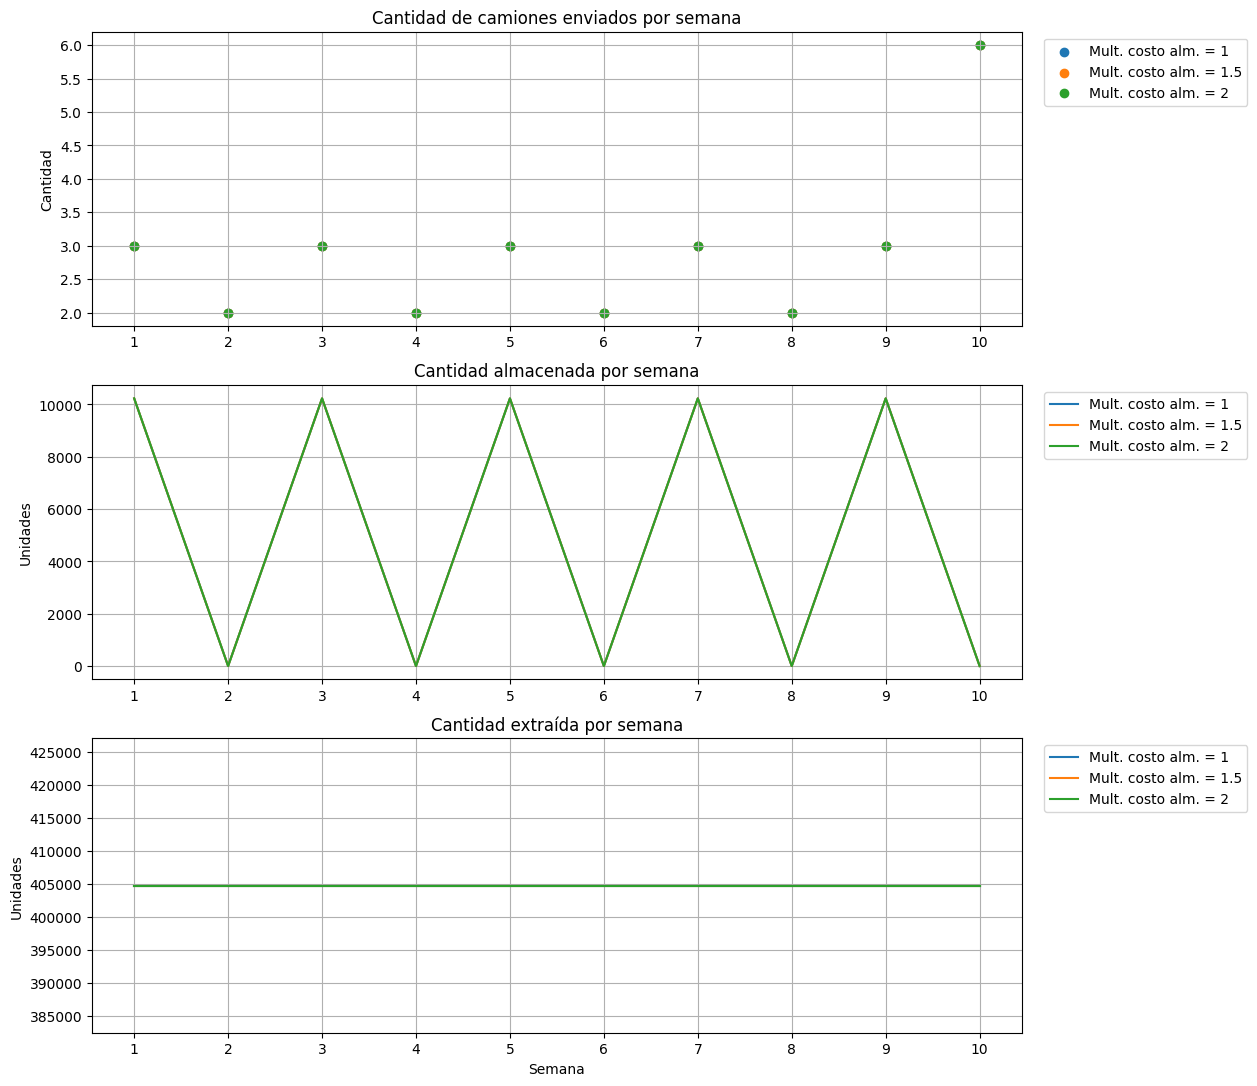

[[3. 3. 3.]
 [2. 2. 2.]
 [3. 3. 3.]
 [2. 2. 2.]
 [3. 3. 3.]
 [2. 2. 2.]
 [3. 3. 3.]
 [2. 2. 2.]
 [3. 3. 3.]
 [6. 6. 6.]]
[[10232. 10233. 10233.]
 [    0.     0.     0.]
 [10233. 10233. 10233.]
 [    0.     0.     0.]
 [10232. 10233. 10233.]
 [    0.     0.     0.]
 [10233. 10233. 10233.]
 [    0.     0.     0.]
 [10232. 10233. 10233.]
 [    0.     0.     0.]]
[[404777. 404777. 404777.]
 [404777. 404777. 404777.]
 [404777. 404777. 404777.]
 [404777. 404777. 404777.]
 [404777. 404777. 404777.]
 [404777. 404777. 404777.]
 [404777. 404777. 404777.]
 [404777. 404777. 404777.]
 [404777. 404777. 404777.]
 [404777. 404777. 404777.]]


In [26]:
cam_comparison = np.zeros((tmax, 3))
al_comparison = np.zeros((tmax, 3))
ext_comparison = np.zeros((tmax, 3))
prueba = 1

# Prueba 1: cambiar costo de almacenamiento
# mult_costo_alm = [1,1.5,2]

for p in range(3):
    # Tr[a,i,j,k,t,e, prueba, p]
    # Cam[e,i,j,k,t, prueba, p]
    # Al[a,i,k,t, prueba, p]
    # ExT[a,i,k,t, prueba, p]
    Cam_sum_t = np.sum(Cam[:,:,:,:,:,1,p], axis=(0,1,2,3)) # [tiempos, 0, p=p]
    cam_comparison[:,p] = Cam_sum_t
    Al_sum_t = np.sum(Al[:,:,:,:,1,p], axis=(0,1,2))
    # print(Al_sum_t.shape)
    al_comparison[:,p] = Al_sum_t
    ExT_sum_t = np.sum(ExT[:,:,:,:,1,p], axis=(0,1,2))
    # print(ExT_sum_t.shape)
    ext_comparison[:,p] = ExT_sum_t

fig, ax = plt.subplots(3,1)
fig.set_size_inches(12,13)
for p in range(3):
    ax[0].scatter(T, cam_comparison[:,p], label=f"Mult. costo alm. = {mult_costo_alm[p]}")
    ax[0].set_title("Cantidad de camiones enviados por semana")
    ax[1].plot(T, al_comparison[:,p], label=f"Mult. costo alm. = {mult_costo_alm[p]}")
    ax[1].set_title("Cantidad almacenada por semana")
    ax[2].plot(T, ext_comparison[:,p], label=f"Mult. costo alm. = {mult_costo_alm[p]}")
    ax[2].set_title("Cantidad extraída por semana")
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
# fig.suptitle("Comparación según multiplicador de demanda")
ax[0].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[1].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[2].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[2].set_xlabel("Semana")
ax[0].set_ylabel("Cantidad")
ax[1].set_ylabel("Unidades")
ax[2].set_ylabel("Unidades")
# ax.ticklabel_format(useOffset=False)
# ax.set_yticks([0,1,2,3,4,5,6,7,8])
ax[0].set_xticks(T)
ax[1].set_xticks(T)
ax[2].set_xticks(T)
plt.show()

print(cam_comparison)
print(al_comparison)
print(ext_comparison)

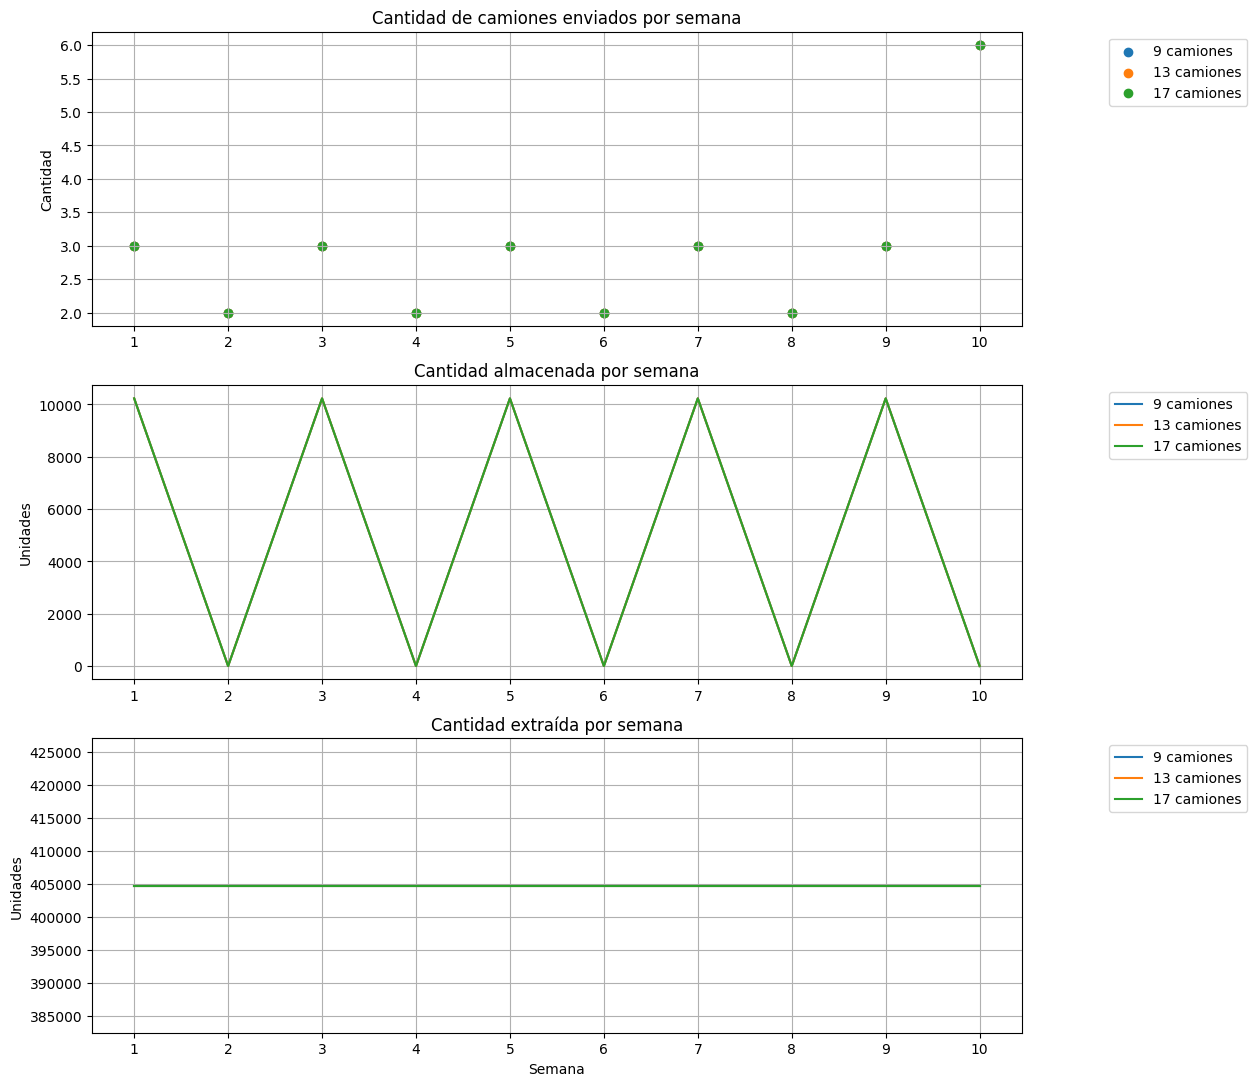

In [30]:
cam_comparison = np.zeros((tmax, 3))
al_comparison = np.zeros((tmax, 3))
ext_comparison = np.zeros((tmax, 3))
prueba = 2

# Prueba 2: cambiar cantidad de camiones
# array_camiones =  [9,13,17]

for p in range(3):
    # Tr[a,i,j,k,t,e, prueba, p]
    # Cam[e,i,j,k,t, prueba, p]
    # Al[a,i,k,t, prueba, p]
    # ExT[a,i,k,t, prueba, p]
    Cam_sum_t = np.sum(Cam[:,:,:,:,:,2,p], axis=(0,1,2,3)) # [tiempos, 0, p=p]
    cam_comparison[:,p] = Cam_sum_t
    Al_sum_t = np.sum(Al[:,:,:,:,2,p], axis=(0,1,2))
    # print(Al_sum_t.shape)
    al_comparison[:,p] = Al_sum_t
    ExT_sum_t = np.sum(ExT[:,:,:,:,2,p], axis=(0,1,2))
    # print(ExT_sum_t.shape)
    ext_comparison[:,p] = ExT_sum_t

fig, ax = plt.subplots(3,1)
fig.set_size_inches(12,13)
for p in range(3):
    ax[0].scatter(T, cam_comparison[:,p], label=f"{array_camiones[p]} camiones")
    ax[0].set_title("Cantidad de camiones enviados por semana")
    ax[1].plot(T, al_comparison[:,p], label=f"{array_camiones[p]} camiones")
    ax[1].set_title("Cantidad almacenada por semana")
    ax[2].plot(T, ext_comparison[:,p], label=f"{array_camiones[p]} camiones")
    ax[2].set_title("Cantidad extraída por semana")
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
# fig.suptitle("Comparación según multiplicador de demanda")
ax[0].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[1].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[2].legend(loc='upper right', bbox_to_anchor=[1.25, 1])
ax[2].set_xlabel("Semana")
ax[0].set_ylabel("Cantidad")
ax[1].set_ylabel("Unidades")
ax[2].set_ylabel("Unidades")
# ax.ticklabel_format(useOffset=False)
# ax.set_yticks([0,1,2,3,4,5,6,7,8])
ax[0].set_xticks(T)
ax[1].set_xticks(T)
ax[2].set_xticks(T)
plt.show()